# 🔥 **Importy**

In [1]:
from our_library.our_reusable_methods import *

import pandas as pd
import seaborn as sns
import itertools

from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,Lars
from sklearn.svm import SVR
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import warnings
warnings.filterwarnings("ignore")

# 🟢 **Tematyka projektu**
1. Stworzenie modelu regresji do przewidywania ilości spożywanego przez młodzież alkoholu zależnie od czynników środowiskowych.
2. Skorzystano ze zbioru [student-alcohol-consumption](https://data.world/data-society/student-alcohol-consumption)
3. Oryginalny zbiór zawiera dane z podziałem na szkoły i 2 tabele posiadają dane na temat ocen z matematyki oraz języka. Połączono obie tabelki w jedną i usunięto niepotrzebne kolumny. Zmienne opisywane to spożycie w tygodniu oraz w weekendy. Połączono obie zmienne w jedną we wspólny współczynnik patologicznego spożycia, gdzie picie w tygodniu będzie liczone z wyższą wagą.

# 🟠 **Przygotowanie Danych**

In [2]:
# wczytanie zbioru i usunięcie niepotrzebnych nam kolumn
d1 = pd.read_csv("student-mat.csv")
d2 = pd.read_csv("student-por.csv")
# łączę obie tabelki w jedną
dataset = pd.concat([d1,d2], ignore_index=True)
# istnieje część wspólna obu tabelek więc usuwam kolumny niepotrzebne i z założenia różniące obie tabele i usuwam duplikaty, czyli wystąpienia tych samych uczniów
dataset = dataset.drop(columns=["G1","G2","G3","paid"]).drop_duplicates(ignore_index=True)
# zakładam, że picie w tygodniu dwukrotnie mocniej wskazuje na problem alkoholowy
dataset['alc'] = 2 * dataset.Dalc + dataset.Walc
# usuwam kolejne zbędne kolumny
dataset = dataset.drop(columns=["school","Dalc","Walc"])
# usunięcie rekordów z brakami
dataset = dataset.dropna()
# prosta binaryzacja atrybutów tam gdzie to możliwe, 
# dobieram wartości tak, aby rosły wraz ze stopniem depresji
dataset.sex = dataset.sex.apply(lambda x:0 if x=="F" else 1)
dataset.address = dataset.address.apply(lambda x:0 if x=="R" else 1)
dataset.famsize = dataset.famsize.apply(lambda x:0 if x=="LE3" else 1)
dataset.Pstatus = dataset.Pstatus.apply(lambda x:0 if x=="T" else 1)
# zamiast pisać ręcznie dla każdej jak powyżej
yes_no_columns = ['schoolsup','famsup','activities','nursery','higher','internet','romantic']
for c in yes_no_columns:
    dataset[c] = dataset[c].apply(lambda x:0 if x=="no" else 1)
# binaryzacja techniką one-hot-encode atrybytów kategorycznych
features_to_encode = ['Mjob','Fjob','reason','guardian']
encoder = OneHotEncoder()
results = encoder.fit_transform(dataset.loc[:,features_to_encode])
# zamiana starych atr. kat. na nowe one-hot-y
dataset_without_categoricals = dataset.drop(columns=features_to_encode).reset_index().drop(columns=["index"])
encoded_categoricals = pd.DataFrame(results.toarray(), columns=encoder.get_feature_names(features_to_encode)).reset_index().drop(columns=["index"])
dataset = pd.concat([dataset_without_categoricals, encoded_categoricals], axis=1)
# zamiana typów danych na int64
dataset = dataset.convert_dtypes()
# zamiana nazw kolumn na lowercase
dataset.columns = [c.lower() for c in dataset.columns]
# zamiana kolejności kolumn na alfabetyczną
dataset = dataset[sorted(dataset.columns)]

# 🔵 **Oglądanie Danych**

(0.0, 25.0)

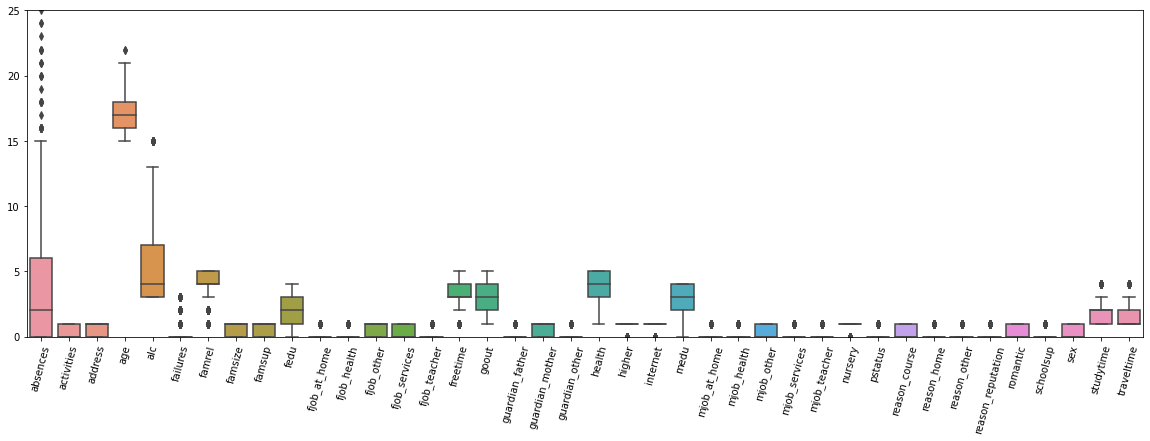

In [15]:
plt.figure(figsize=(20,6))
ax = sns.boxplot(data=dataset)
ax.set_xticklabels(ax.get_xticklabels(),rotation=75);
# celowo ucinam punkty oddalone z wykresu
ax.set_ylim(0,25)
#ax.set_yscale('log')

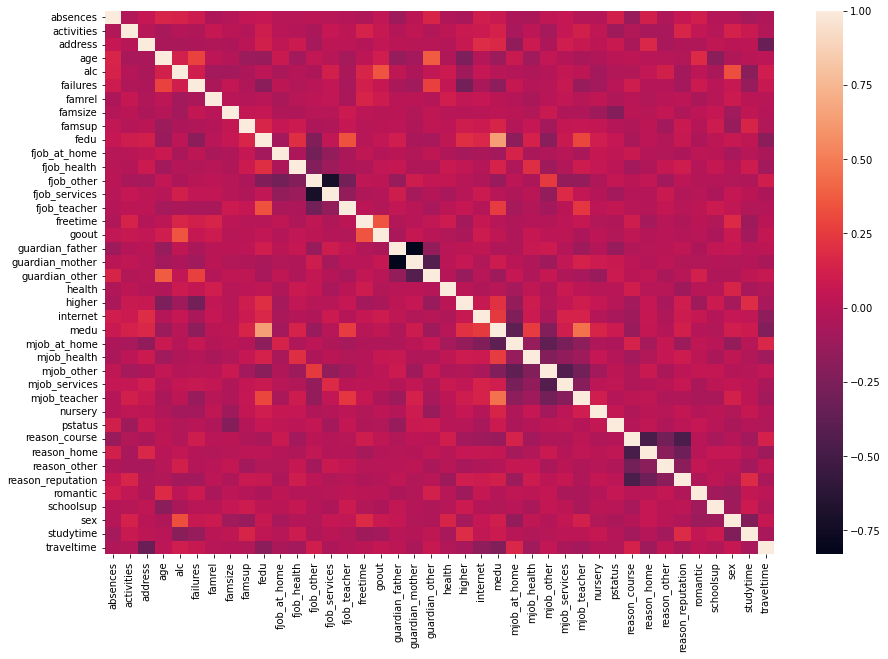

In [29]:
plt.figure(figsize=(15,10))
corr = dataset.corr()
sns.heatmap(data=corr);

![title](https://miro.medium.com/max/932/1*Qz_gwy4ZaSZuOpl3IyO2HA.png)

In [87]:
corr_list = list(itertools.chain(*[[(r,c,corr.loc[r,c]) for r in corr.columns] for c in corr.columns]))
sorted_abs_corr_list = sorted(corr_list,key=lambda x:abs(x[2]), reverse=True)
sorted_abs_corr_list = list(filter(lambda x:x[0]!=x[1] and abs(x[2]) > 0.5, sorted_abs_corr_list))[::2]
sorted_abs_corr_list

[('guardian_mother', 'guardian_father', -0.8303691651611663),
 ('fjob_services', 'fjob_other', -0.7115110067483373),
 ('medu', 'fedu', 0.6377898316505468)]

- wykształcenie matki i ojca są skorelowane
- opieką w razie rozwodu może zajmować się albo ojciec albo matka stąd ujemna korelacja guardian_
- 

# 🟡 **Skalowanie Danych**

In [6]:
# skalowanie minmax, nie wpływa na nasze atr. binarne, ale wyrównuje wpływ z pozostałymi atrybutami
scaler = MinMaxScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns = dataset.columns)
# podział wyczyszczonego zbioru na części, wszystko robimy na treningowym (włącznie z walidacją), 
# a testowy dopiero na sam koniec dla już wybranego modelu
X_train, X_test, y_train, y_test = train_test_split(dataset.drop(columns=['alc']), dataset['alc'], test_size=0.2, random_state=1)

# 🟣 **Szukanie Modelu**
Przetestujemy następujące modele regresji:
- Multiple LinearRegression
- Ridge
- Lasso
- Elastic-Net
- SVR with kernel:

<ol>
<li>Poly</li>
<li>Linear</li>
<li>RBF</li>
</ol>

- Least Angle Regression

# Wieloraka Regresja Liniowa
Nie posiada żadnych hiperparametrów.

# Regresja Grzbietowa

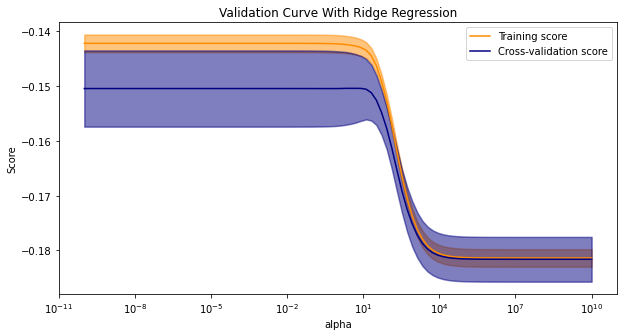

In [8]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = Ridge(random_state=1),
    model_name = "Ridge Regression",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,10,100),
    param_name = "alpha",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

# Regresja Lasso

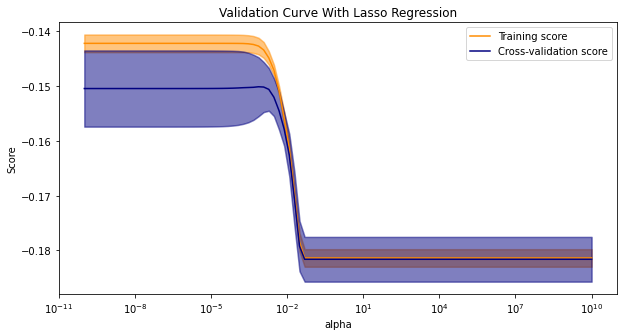

In [10]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = Lasso(random_state=1),
    model_name = "Lasso Regression",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,10,100),
    param_name = "alpha",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

# Elastic-Net

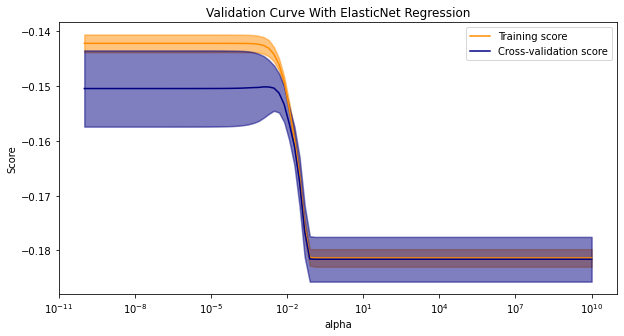

In [12]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = ElasticNet(random_state=1),
    model_name = "ElasticNet Regression",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,10,100),
    param_name = "alpha",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

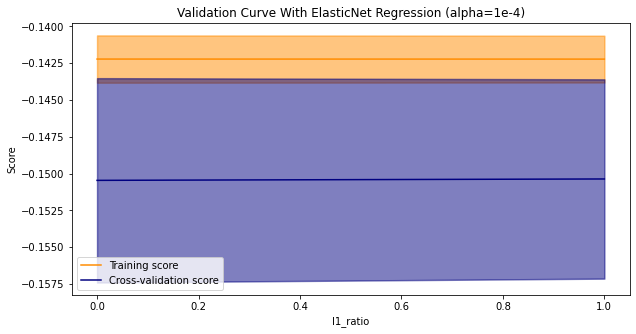

In [13]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = ElasticNet(random_state=1,alpha=1e-4),
    model_name = "ElasticNet Regression (alpha=1e-4)",
    X = X_train,
    y = y_train,
    param_range = np.arange(0,1.01,0.01),
    param_name = "l1_ratio",
    scoring = "neg_mean_absolute_error",
    xscale = "lin"
)

# SVM Z Jądrem Wielomianowym

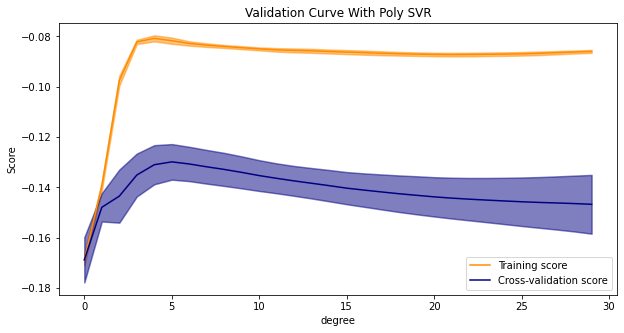

In [15]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="poly"),
    model_name = "Poly SVR",
    X = X_train,
    y = y_train,
    param_range = np.arange(0,30),
    param_name = "degree",
    scoring = "neg_mean_absolute_error",
    xscale = "lin"
)

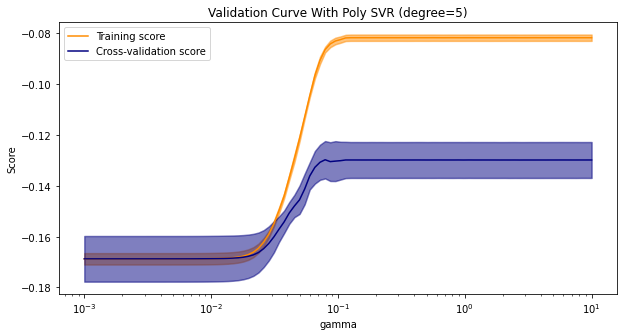

In [16]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="poly",degree=5),
    model_name = "Poly SVR (degree=5)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-3,1,100),
    param_name = "gamma",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

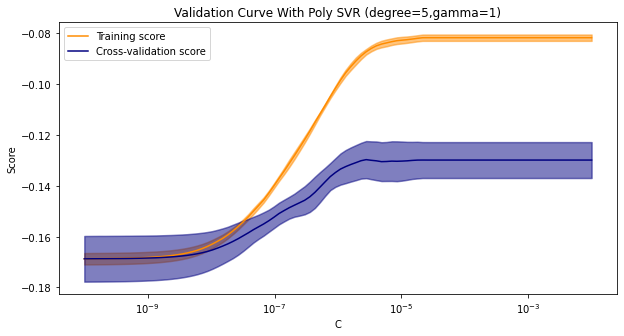

In [17]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="poly",degree=5,gamma=1),
    model_name = "Poly SVR (degree=5,gamma=1)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,-2,100),
    param_name = "C",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

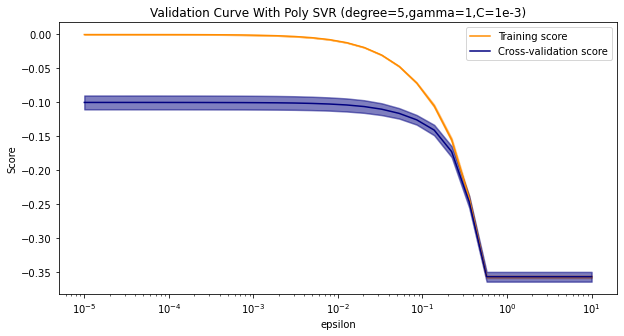

In [18]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="poly",degree=5,gamma=1,C=1e-3),
    model_name = "Poly SVR (degree=5,gamma=1,C=1e-3)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-5,1,30),
    param_name = "epsilon",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

# SVM Z Jądrem Liniowym

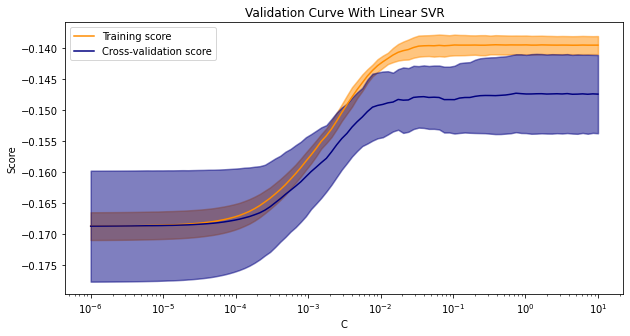

In [20]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="linear"),
    model_name = "Linear SVR",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-6,1,100),
    param_name = "C",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

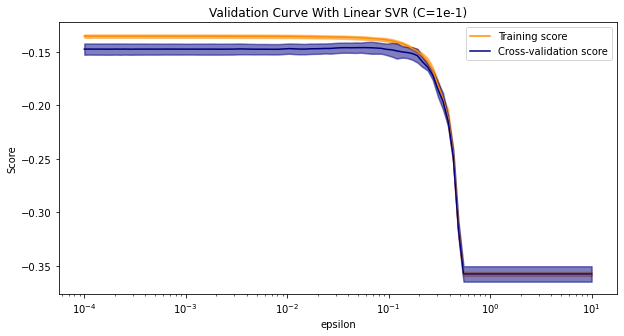

In [21]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="linear",C=1e-1),
    model_name = "Linear SVR (C=1e-1)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-4,1,100),
    param_name = "epsilon",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

# SVM Z Jądrem RBF

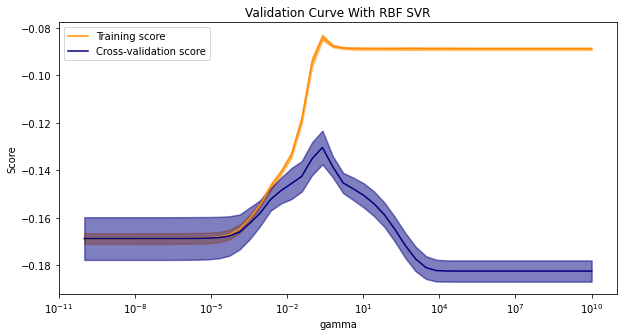

In [23]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="rbf"),
    model_name = "RBF SVR",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,10,50),
    param_name = "gamma",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

In [24]:
sorted(zip(np.logspace(-10,10,50), validation_scores_mean), key=lambda x:x[1])[-1]

(0.2442053094548655, -0.1304057051786754)

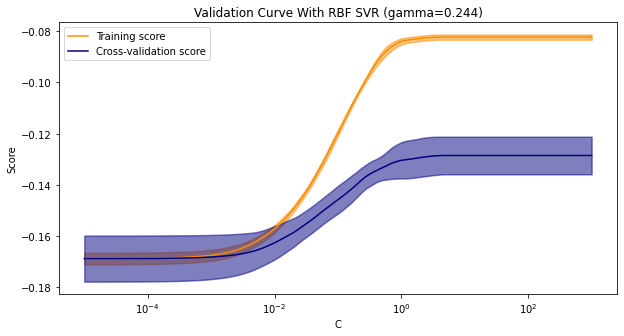

In [25]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="rbf",gamma=0.244),
    model_name = "RBF SVR (gamma=0.244)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-5,3,100),
    param_name = "C",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

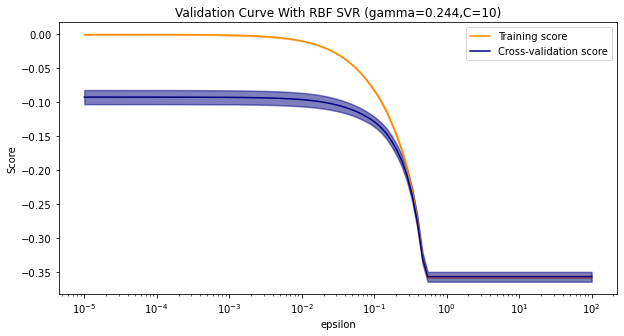

In [26]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = SVR(kernel="rbf",gamma=0.244,C=10),
    model_name = "RBF SVR (gamma=0.244,C=10)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-5,2,100),
    param_name = "epsilon",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

# Least Angle Regression

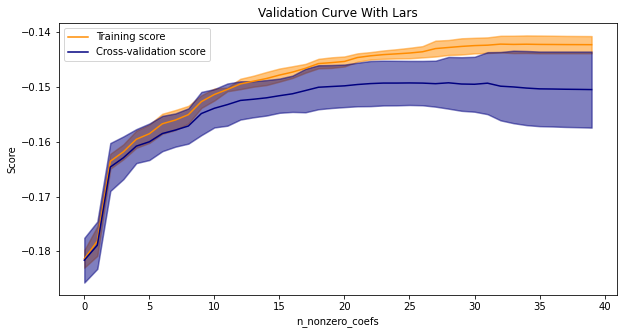

In [28]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = Lars(random_state=1),
    model_name = "Lars",
    X = X_train,
    y = y_train,
    param_range = np.arange(0,len(X_train.columns)+1),
    param_name = "n_nonzero_coefs",
    scoring = "neg_mean_absolute_error",
    xscale = "lin"
)

In [29]:
sorted(zip(np.arange(0,len(X_train.columns)+1), validation_scores_mean), key=lambda x:x[1])[-1]

(28, -0.14921192417637566)

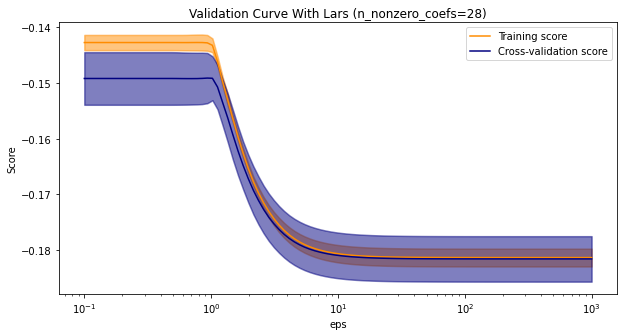

In [30]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = Lars(random_state=1, n_nonzero_coefs=28),
    model_name = "Lars (n_nonzero_coefs=28)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-1,3,100),
    param_name = "eps",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

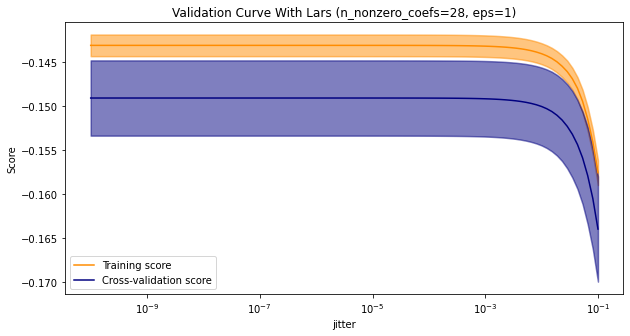

In [31]:
train_scores_mean, validation_scores_mean = plot_validation_curve(
    model = Lars(random_state=1, n_nonzero_coefs=28, eps=1),
    model_name = "Lars (n_nonzero_coefs=28, eps=1)",
    X = X_train,
    y = y_train,
    param_range = np.logspace(-10,-1,100),
    param_name = "jitter",
    scoring = "neg_mean_absolute_error",
    xscale = "log"
)

# 🟢 **Najlepsze Modele**
Wybrane ręcznie najlepsze modele.

In [52]:
best_models = [
    LinearRegression(),
    Ridge(alpha=1e-2,random_state=1), 
    Lasso(alpha=1e-4,random_state=1), 
    ElasticNet(alpha=1e-4,random_state=1), 
    SVR(kernel="poly",degree=5,gamma=1,C=1e-3,epsilon=1e-3), 
    SVR(kernel="linear",C=1e-1,epsilon=1e-2), 
    SVR(kernel="rbf",gamma=0.244,C=10,epsilon=1e-3), 
    Lars(random_state=1,n_nonzero_coefs=28,eps=1,jitter=None)
]
test_scores = [test_model(model,X_train,y_train,X_test,y_test) for model in best_models]
dict(sorted(zip(best_models,test_scores), key=lambda x:x[1]))

{SVR(C=10, epsilon=0.001, gamma=0.244): 0.09587423674738878,
 SVR(C=0.001, degree=5, epsilon=0.001, gamma=1, kernel='poly'): 0.10258633516771051,
 SVR(C=0.1, epsilon=0.01, kernel='linear'): 0.15520499574574975,
 Lars(eps=1, n_nonzero_coefs=28, random_state=1): 0.15965595912042152,
 Lasso(alpha=0.0001, random_state=1): 0.16151925079805596,
 ElasticNet(alpha=0.0001, random_state=1): 0.1615961737448593,
 Ridge(alpha=0.01, random_state=1): 0.16167848095960705,
 LinearRegression(): 0.16262647029505584}

# 🟠 **Wyniki W Dziedzinie Kategorii**
Z rozumienia zbioru danych wyłaniam 7 kategorii atrybutu opisywanego "alc": <br>
<ol>
<li>Prawie Wcale</li>
<li>Bardzo Mało</li>
<li>Mało</li>
<li>Średnio</li>
<li>Sporo</li>
<li>Dużo</li>
<li>Bardzo Dużo</li>
</ol>
Porówam najlepsze modele pod kątem ich wyników precision,recall,f1. 

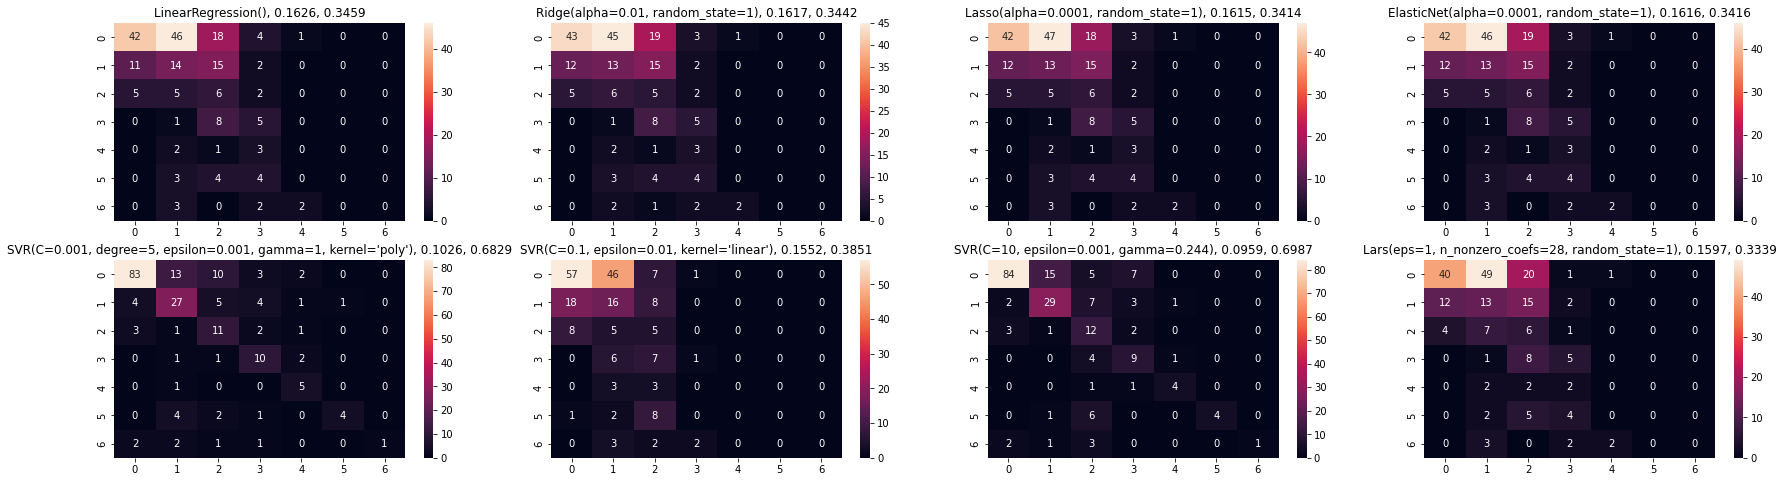

In [219]:
fig,axes = plt.subplots(4,2)
fig.set_figwidth(30)
fig.set_figheight(8)
for ax,model,test_score in zip(list(itertools.chain(*axes)),best_models,test_scores):
    test_score = round(test_score,4)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    conf = confusion_matrix(*convert_to_categoricals(y_test,y_pred,7))
    f1 = round(f1_score(*convert_to_categoricals(y_test,y_pred,7), average="weighted"),4)
    ax.set_title(f"{model}, {test_score}, {f1}")
    sns.heatmap(conf, annot=conf, ax=ax)

# 🔵 **Wnioski**
Najlepszy wynik udało się osiągnąć dla modelu SVR z jądrem Gaussa. Drugi również godny uwagi model SVR z jądrem wielomianowym. Błąd testowania najlepszego modelu wynosi około 0.096 co stanowi bardzo dobry wynik biorąc pod uwagę nasze dane. Bowiem błąd około 0.1 to połowa różnicy między kolejnymi stopniami alkoholizmu, więc wynik powinien być bardzo sensowny. W oryginalnych danych alkoholizm był określany w skali 1-5 (very low, low, avg, high, very high). Po przeskalowaniu na zakres 0-1, jednemu punktowi w skali odpowiada 0.2. Nasz błąd to około 0.1. Oznacza to, że nasz model nie myli się bardziej niż o pół stopnia w skali czyli np. kogoś kto pije mało zaklasyfikuje w najgorszym razie jako w połowie drogi do pijącego bardzo mało lub średnio. Największe błędy model osiąga dla osób, których warunki środowiskowe są bardzo trudne ale osoby te mają silny charakter i nie przesadzają z alkoholem pomimo trudnego życia (to bardzo optymistyczne :)). W dziedzinie kategorii nasz wybrany model również jest najlepszy i sądzę, że zadowalający. Trochę myli kategorie 0,1 czyli niepijących wcale z bardzo mało co jest zrozumiałe. Myli również bardzo mało z mało (1,2) i mało ze średnio (2,3). Jednak pamiętajny, że jest to problem regresji, a nie klasyfikacji. Poza tym często zdarzają sie dzieci ze świetnymi warunkami z bogatych domów, które marnują sobie życie i wpadają w kategorię ostatnią lub o wiele wyższą niż by się można spodziewać. Oczywiście i to możnaby uchwycić ale z większą liczbą atrybutów (lub innymi, bardziej psychologicznymi), ponieważ alkoholizm również ma podłoże psychologiczne, którego nasze atrybuty nie badają tak dokładnie. Ciekawe wyniki mógłby dać model uczony na danych rozszerzonych o właśnie psychologiczne.